In [18]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import json
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
from torch.utils.data import DataLoader

from dataset_CELTIC import CELTICDataGen
from models.MaskGenerator_CELTIC import MaskGenerator
from models.UNETO_CELTIC import UNet3D
from models.fnet_model import CELTICModel
from transforms import normalize, normalize_with_mask, Propper


In [19]:
class CELTICWrapper(nn.Module):
    def __init__(self, celtic_model):
        super().__init__()
        self.model = celtic_model
        self.model.net.eval()
        for param in self.model.net.parameters():
            param.requires_grad = False  # Freeze weights

    def forward(self, signal: torch.Tensor, context: torch.Tensor = None, m = None):
        # Assumes signal is (1, C, D, H, W), context is (1, F)
        # with torch.no_grad():
        #     if context is not None:
        #         return self.model.net(signal, context)
        #     else:
        #         return self.model.net(signal)

        if context is not None:
            pred = self.model.net(signal, context)
            pred = pred * m
        else:
            pred = self.model.net(signal)
            pred = pred * m
        return pred


In [20]:
# Define base path for all operations
BASE_PATH = f'/{"/".join(os.getcwd().split("/")[1:-1])}'
RESOURCES_PATH = BASE_PATH + "/resources/resources"
print(BASE_PATH)
print(RESOURCES_PATH)

/home/gadmicha/Nitsan_New
/home/gadmicha/Nitsan_New/resources/resources


In [21]:
# --- Configuration ---
CONTINUE_TRAINING = True
weighted_pcc = False
signals_are_masked = True
organelle = "Nuclear-envelope"
organelle_path = organelle.lower()

unet_model_path = f"{RESOURCES_PATH}/{organelle}/models/best_model_context.p"
mg_model_path = f"{BASE_PATH}/mg/{organelle}/model.pt"
data_path = f"/sise/assafzar-group/assafzar/Nitsan/hipsc_single_cell_image_dataset/{organelle_path}/fov_processed/cells/source/"
train_csv_path = f"{RESOURCES_PATH}/{organelle}/metadata/train_images.csv"
train_context_path = f"{RESOURCES_PATH}/{organelle}/metadata/train_context.csv"
validation_csv_path = f"{RESOURCES_PATH}/{organelle}/metadata/valid_images.csv"
validation_context_path = f"{RESOURCES_PATH}/{organelle}/metadata/valid_context.csv"
patch_size = (32, 64, 64, 1)


In [22]:
# --- Load context config ---
with open(f"{RESOURCES_PATH}/{organelle}/models/context_model_config.json", 'r') as file:
    context_model_config = json.load(file)


In [23]:
transforms_config = context_model_config["transforms"]

# Evaluate each string in the config using `eval`, injecting train_patch_size
transforms = {
    k: eval(v, {"normalize": normalize,
                "normalize_with_mask": normalize_with_mask,
                "Propper": Propper,
                "train_patch_size": patch_size[:-1]})
    for k, v in transforms_config.items()
}

In [24]:
# === Load Datasets ===
train_dataset = CELTICDataGen(train_csv_path, data_path, train_context_path, transforms, signals_are_masked)
val_dataset = CELTICDataGen(validation_csv_path, data_path, validation_context_path, transforms, signals_are_masked)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


Signal shape: torch.Size([1, 1, 32, 192, 192])
Target shape: torch.Size([1, 1, 32, 192, 192])
Context shape: torch.Size([1, 16])


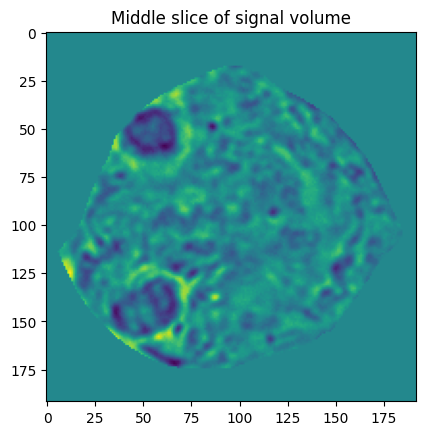

In [25]:
# Get a batch from the train loader
(sample_batch, target_batch, mask) = next(iter(train_loader))

# Unpack signal and context
signal, context_ex = sample_batch

# # Print shapes
print("Signal shape:", signal.shape)         # Expected: (1, C, D, H, W)
print("Target shape:", target_batch.shape)   # Expected: (1, C, D, H, W)
print("Context shape:", context_ex.shape)       # Expected: (1, num_features)

# Optionally: visualize a slice of the volume (e.g., middle slice in depth)

middle_slice = signal.shape[2] // 2
plt.imshow(signal[0, 0, middle_slice].cpu().numpy(), cmap='viridis')
plt.title("Middle slice of signal volume")
plt.show()

In [26]:
context_features = context_model_config['context_features']
daft_embedding_factor = context_model_config['daft_embedding_factor']
daft_scale_activation = context_model_config['daft_scale_activation']

context_df = pd.read_csv(train_context_path)
context = {
    'context_features': context_features,
    'context_features_len': context_df.shape[1],
    'daft_embedding_factor': daft_embedding_factor,
    'daft_scale_activation': daft_scale_activation
}


In [27]:
%%capture

# --- Load CELTIC model ---
celtic_model = CELTICModel(context=context, signals_are_masked=signals_are_masked)
celtic_model.load_state(unet_model_path)
celtic_wrapper = CELTICWrapper(celtic_model)


In [28]:
%%capture

# Assuming these are already loaded:
# signal: torch.Tensor of shape (1, 1, D, H, W)
# context: torch.Tensor of shape (1, F)

# Optionally move to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
celtic_model.net.to(device)


In [29]:
signal = signal.to(device)
context_ex = context_ex.to(device)
mask = mask.to(device)

In [30]:
# Run prediction using wrapper (batch size 1)

# signal_np = signal.squeeze(0).numpy()   # (1, D, H, W)
# context_np = context_ex.squeeze(0).numpy()  # (F,)

# prediction = celtic_wrapper(signal_np, context_np)
prediction = celtic_wrapper(signal, context_ex, mask)


In [31]:
prediction.shape

torch.Size([1, 1, 32, 192, 192])

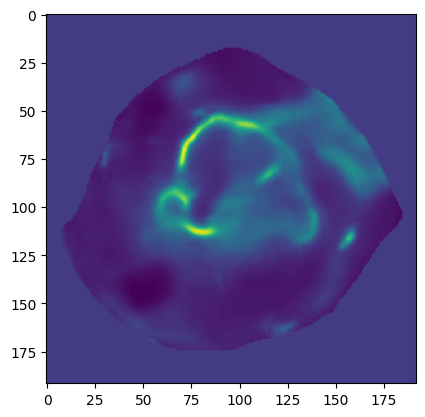

In [32]:
plt.imshow(prediction.cpu()[0,0,16], cmap='viridis')

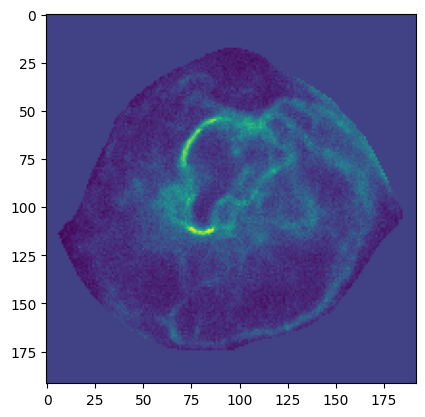

In [34]:
plt.imshow(target_batch[0,0,16], cmap='viridis')

In [35]:
# === Initialize Models ===
unet = UNet3D(in_channels=2, out_channels=1)


In [36]:
mg = MaskGenerator(patch_size, unet, celtic_wrapper, mask_loss_weight=0.95, weighted_pcc=weighted_pcc,
                   pcc_target=0.92)


/home/gadmicha/Nitsan_New/MASK/models/MaskGenerator_CELTIC.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()


In [37]:
if CONTINUE_TRAINING and os.path.exists(mg_model_path):
    mg.load_state_dict(torch.load(mg_model_path))

In [38]:
# === Training Setup ===
mg.to(device)
num_epochs = 100
optimizer = optim.Adam(mg.parameters(), lr=0.0001)

In [39]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=True, path=f"{mg_model_path}"):
        self.patience = patience
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.verbose:
                print(f"[EarlyStopping] No improvement for {self.counter} epoch(s).")
            if self.counter >= self.patience:
                if self.verbose:
                    print("[EarlyStopping] Stopping training.")
                self.early_stop = True

    def save_checkpoint(self, model):
        if self.verbose:
            print(f"[EarlyStopping] Validation loss improved. Saving model to {self.path}")
        torch.save(model.state_dict(), self.path)


In [ ]:
mw = mg.mask_loss_weight
lr = optimizer.param_groups[0]['lr']
early_stopper = EarlyStopping(path=f"{mg_model_path[:-3]}_mw_{mw}_lr_{lr}.pt")

print("Starting training...")
for epoch in range(num_epochs):
    mg.train()
    for (x, context), y, m in train_loader:
        x, y, context, m = x.to(device), y.to(device), context.to(device), m.to(device)
        loss_dict = mg.train_step((x, context), y, m, optimizer)
    print(f"Epoch {epoch}: {loss_dict}")

    mg.eval()
    val_losses = []
    with torch.no_grad():
        for (x, context), y, m in val_loader:
            x, y, context, m = x.to(device), y.to(device), context.to(device), m.to(device)
            val_loss_dict = mg.test_step((x, context), y, m)
            val_losses.append(val_loss_dict["val_loss"])
    avg_val_loss = sum(val_losses) / len(val_losses)
    print(f"Validation: {val_loss_dict}")

    # Maybe use single batch and not average
    early_stopper(avg_val_loss, mg)
    if early_stopper.early_stop:
        break

print("Training complete.")
